In [16]:
import pandas as pd
good=pd.read_pickle("../parsed data/simplifiedshodangood")
bad=pd.read_pickle("../parsed data/simplifiedshodanbad")

good.insert(0,"malicious",0)
bad.insert(0,"malicious",1)
combined=good.append(bad,ignore_index=True)
bad=bad.drop_duplicates(subset="indicator")

#combined=combined.sample(frac=1)
#combined=combined.drop_duplicates("ip_str")



In [2]:
earlybad=bad.head(100000)
latebad=bad.tail(61638)

#data is collected in ascending order, so splitting by date it is just a matter of splitting the dataframe by index
train=pd.concat([good.head(20000),earlybad.sample(20000)],ignore_index=True)
test=pd.concat([good.tail(7000),latebad.sample(7000)],ignore_index=True)

train=train.sample(frac=1)
test=test.sample(frac=1)

del earlybad,latebad
del bad, good
#first 40000 are training, last 14000 are testing
temp=pd.concat([train,test])
del train,test

In [3]:
from sklearn.preprocessing import OneHotEncoder
x=temp["country_code"]
z=x.values.reshape(-1,1)

for i in range(len(z)):
    if z[i][0] is None:
        z[i][0]="None"
        
superhot=OneHotEncoder()
country=superhot.fit_transform(z)

country=country.toarray()

del x
del z

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import scipy 
import numpy as np

productlabelizer=MultiLabelBinarizer()
encodedproducts=productlabelizer.fit_transform(temp["products"])

ports=list(range(0,65536))

mlb=MultiLabelBinarizer(classes=ports)
del ports
encodedports=mlb.fit_transform(temp['ports'])



encodedports=np.concatenate([encodedports,encodedproducts,country],axis=1)


xtrain=encodedports[0:40000]
xtest=encodedports[40000:]

ytrain=temp[0:40000]['malicious']
ytest=temp[40000:]['malicious']

# Logistic regression

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
glm=LogisticRegression()
model=glm.fit(xtrain,ytrain)
print(classification_report(ytest,model.predict(xtest)))


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7000
           1       0.95      0.93      0.94      7000

   micro avg       0.94      0.94      0.94     14000
   macro avg       0.94      0.94      0.94     14000
weighted avg       0.94      0.94      0.94     14000



# Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rfc=RandomForestClassifier()
model=rfc.fit(xtrain,ytrain)
print(classification_report(ytest,model.predict(xtest)))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7000
           1       0.94      0.95      0.95      7000

   micro avg       0.95      0.95      0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000



In [7]:
portimport=rfc.feature_importances_
sortedports=np.argsort(portimport[0:65536])[::-1]

In [12]:
plt.close()

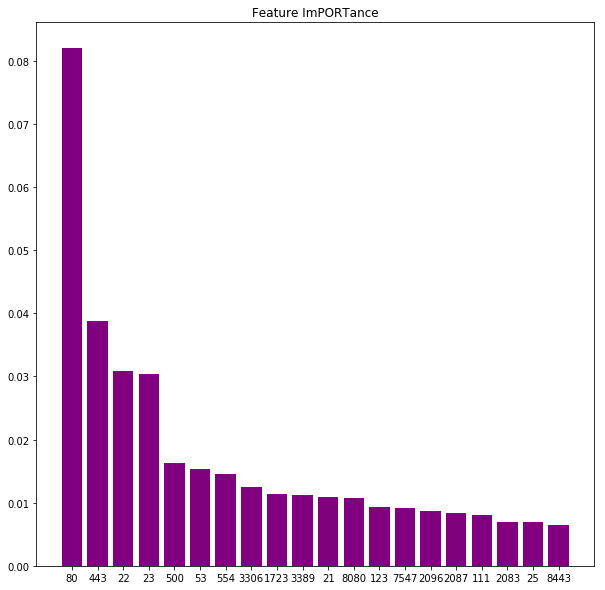

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title("Feature ImPORTance")
plt.bar(np.arange(20),portimport[sortedports[0:20]],color="purple",align="center")
plt.xticks(np.arange(20),sortedports[0:20])
plt.show()


# Neural Net

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
mlp=MLPClassifier(verbose=True,max_iter=45)
model=mlp.fit(xtrain,ytrain)
print(classification_report(ytest,model.predict(xtest)))

In [ ]:

print(classification_report(ytest,model.predict(xtest)))

# Keras Neural Net

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model = Sequential([Dense(64,input_shape=(66095,)),Activation("relu"),Dense(64),Activation("softmax"),Dense(1),Activation("sigmoid")])
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(xtrain,ytrain,epochs=5,verbose=1,validation_data=(xtest,ytest))

# verifying results

In [ ]:
pred=np.round(model.predict(xtest)).astype(int)

In [ ]:
pred=pred.reshape(len(ytest))

In [ ]:
test=np.equal(ytest.values,pred)

In [ ]:
badzone=xtest[~np.equal(ytest.values,pred),:]
goodzone=xtest[np.equal(ytest.values,pred),:]

In [ ]:
x=mlb.inverse_transform(badzone[:,:65536])
y=mlb.inverse_transform(goodzone[:,:65536])

In [ ]:
X=pd.Series(x)
Y=pd.Series(y)

# printing distribution of ports

In [17]:
badports=bad["ports"].sample(35513).sum()

In [18]:
goodports=good["ports"].sum()

In [43]:
countsb=bad["ports"].apply(lambda x:len(x))

In [3]:
counts=good["ports"].apply(lambda x:len(x))

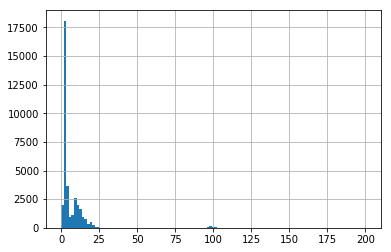

In [56]:
counts.hist(bins=117,range=(0,200),label="Number of open ports",)

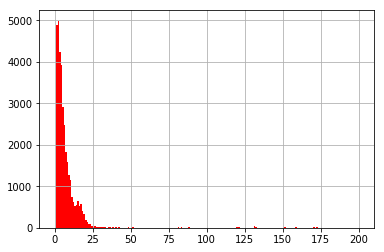

In [57]:
countsb.sample(35513).hist(bins=200,range=(0,200),color="r")

In [19]:
from collections import Counter
gc=pd.Series(Counter(goodports))
bc=pd.Series(Counter(badports))

In [20]:
gc=gc.sort_values(ascending=False)
bc=bc.sort_values(ascending=False)

In [21]:
dc=gc-bc

In [24]:
a=np.arange(984)
b=dc.index.astype(str)

In [22]:
dc=dc.sort_values(ascending=False).dropna()
snipped=pd.concat([dc.head(10),dc.tail(10)])

In [82]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [126]:
snipped

443     15581.0
80      13748.0
2083     4765.0
2087     4764.0
2082     4694.0
8880     4624.0
8443     4304.0
2086     4215.0
2096     2726.0
2095     2473.0
3389    -2201.0
123     -2245.0
554     -2444.0
7547    -2857.0
2000    -3175.0
1723    -3411.0
23      -4139.0
53      -4773.0
500     -5896.0
22      -6488.0
dtype: float64

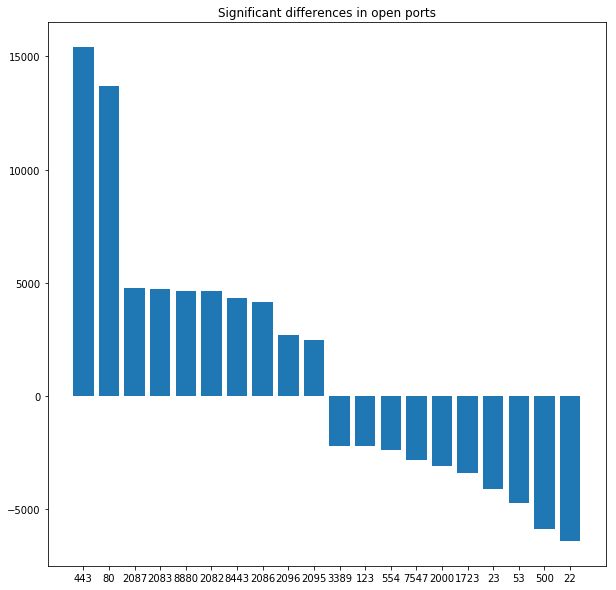

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title("Significant differences in open ports")
plt.bar(list(range(0,20)),snipped.values,align="center")
plt.xticks(np.arange(20),list(snipped.index.astype(str)))
plt.show()

In [66]:
bc

80       21737
443      14689
22       14081
53        8823
500       8359
21        7463
8080      5844
3306      5150
23        4323
25        4306
3389      4114
110       3910
123       3900
143       3838
2000      3715
1723      3668
587       3621
993       3292
995       3214
465       3032
7547      2954
81        2701
111       2688
2082      2444
554       2409
2083      2385
2086      2344
445       2151
2087      2113
8443      2086
         ...  
38693        1
28059        1
63041        1
22473        1
20282        1
3319         1
43452        1
7172         1
614          1
1279         1
276          1
53686        1
37422        1
32524        1
42648        1
16778        1
14906        1
31640        1
7945         1
60263        1
16607        1
1560         1
4495         1
60169        1
17724        1
33805        1
13644        1
62111        1
32324        1
22370        1
Length: 25358, dtype: int64

In [39]:
dc=gc-bc

In [40]:
dc=dc.dropna()

In [41]:
dc

7          -62.0
11          -7.0
13         -47.0
15         -11.0
17         -49.0
19         -67.0
20          -4.0
21       -1567.0
22       -6471.0
23       -4211.0
24           0.0
25         751.0
26         294.0
37         -37.0
43         -13.0
51           0.0
53       -4876.0
69         -74.0
70          -4.0
79          19.0
80       13705.0
81       -1456.0
82        -395.0
83         -38.0
84          64.0
85           1.0
86           5.0
87           5.0
88        -500.0
89          34.0
          ...   
51165       -1.0
51413      -45.0
52869     -248.0
53380       -1.0
53413      -51.0
53560        2.0
54138      -58.0
54439        2.0
54695        0.0
54962        0.0
54984      -25.0
55443      -76.0
55553      -87.0
55554       -8.0
55754        0.0
56014        0.0
58897        3.0
59147       -1.0
59282       -1.0
59517        0.0
60000       -6.0
60129       22.0
60305        0.0
60443        0.0
60485        2.0
60611        0.0
61845        0.0
62078      -39

In [ ]:
gc=gc.sort_index()
bc=bc.sort_index()

In [ ]:
gc.index.shape

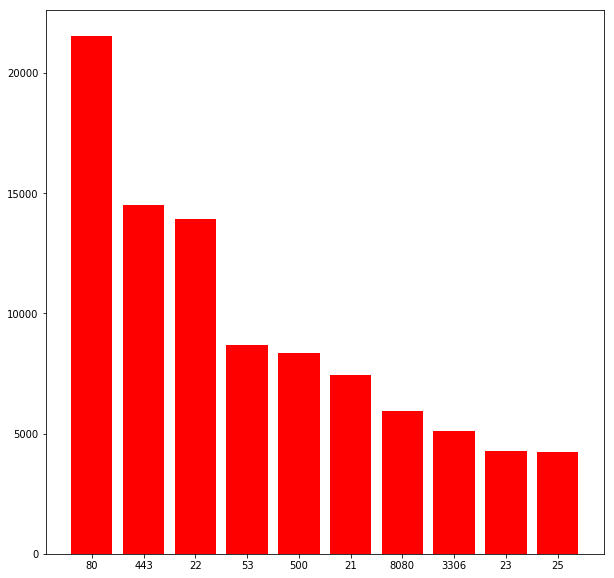

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.bar(list(range(0,10)), bc.values[0:10],color="r")
plt.xticks(list(range(0,10)),list(bc.index))
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
plt.bar(list(range(len(bc))),bc.values)
ylim=1000
plt.show()